In [1]:
# === IMPORTS ===

import numpy as np
import matplotlib.pyplot as plt

from pdfa import PDFA
import machines
import ffutils as ff
from ffutils import STANDARD_TEST, Model, TestConfig

In [2]:
REBER_CONFIG = ff.create_standard_config("reber")
PARITY_CONFIG = ff.create_standard_config("parity")

In [3]:
ff.train_model(STANDARD_TEST, Model.ENSEMBLE, "parity")
ff.test_model(STANDARD_TEST, Model.ENSEMBLE, "parity")

0.153666

In [7]:
# Now my objective is to train ensemble and single model on reber grammar with increasing training set sizes

def generate_sets_size_varied(config: TestConfig, pdfa: PDFA, train_sizes: list[int], test_size: int = 0) -> None:
    # Write increasingly bigger train sets
    trainset = []
    for size in train_sizes:
        trainset = ff.write_trainset(config, pdfa, f"{config.name}_{size}", size, append_to=trainset)
    # Write test set
    if test_size > 0:
        ff.write_testset(config, pdfa, f"{config.name}", test_size)

In [9]:
def evaluate_models_trainsize_varied(config: TestConfig, pdfa: PDFA, train_sizes: list[int], test_size: int, ensemble_sizes: list[int] = [10, 50], log_score: bool = False):

    generate_sets_size_varied(config, pdfa, train_sizes, test_size)
    modes = [(Model.SINGLE, 0)] + [(Model.ENSEMBLE, i) for i in ensemble_sizes]

    perplexities_single: list[float] = []
    perplexities_ensemble: dict[int, list[float]] = {i: [] for i in ensemble_sizes}

    # Train and test each model in both modes
    for i, train_size in enumerate(train_sizes):
        for model_type, nrestimators in modes:
            full_name = f"{config.name}_{train_size}_{nrestimators}"

            # Train the model
            ff.train_model(config, model_type, full_name, f"{config.name}_{train_size}", nrestimators)
            # Test the model
            perplexity = ff.test_model(config, model_type, full_name, config.name)
            # print(f"Tested model {full_name} on {config.name}: {perplexity}")

            if model_type == Model.SINGLE:
                perplexities_single.append(perplexity)
            else:
                perplexities_ensemble[nrestimators].append(perplexity)
        # Print the progress 
        print(f"{i+1}/{len(train_sizes)}", end="\r")

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, perplexities_single, marker='o', label="SINGLE", color="skyblue")
    colormap = plt.colormaps["autumn"]
    get_color = lambda x : colormap(0.7 * (x + 1) / len(ensemble_sizes))
    for i, (nrestimators, perplexities) in enumerate(perplexities_ensemble.items()):
        plt.plot(train_sizes, perplexities, marker='o', label=f"ENSEMBLE_{nrestimators}", color=get_color(i))

    plt.title(f"Perplexity vs Training Set Size ({config.name})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Perplexity")
    plt.xticks(train_sizes)
    if log_score:
        plt.yscale("log")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

Tested model reber_50_0 on reber: 0.0815806
Tested model reber_50_10 on reber: 0.170378
Tested model reber_50_50 on reber: 0.162433
Tested model reber_100_0 on reber: 0.0834202
Tested model reber_100_10 on reber: 0.127482
Tested model reber_100_50 on reber: 0.10522
Tested model reber_150_0 on reber: 0.0832831
Tested model reber_150_10 on reber: 0.0858693
Tested model reber_150_50 on reber: 0.0902497
Tested model reber_200_0 on reber: 0.082794
Tested model reber_200_10 on reber: 0.0836964
Tested model reber_200_50 on reber: 0.0874709
Tested model reber_250_0 on reber: 0.0825307
Tested model reber_250_10 on reber: 0.0839881
Tested model reber_250_50 on reber: 0.0852539
Tested model reber_300_0 on reber: 0.0823939
Tested model reber_300_10 on reber: 0.0836221
Tested model reber_300_50 on reber: 0.0840488


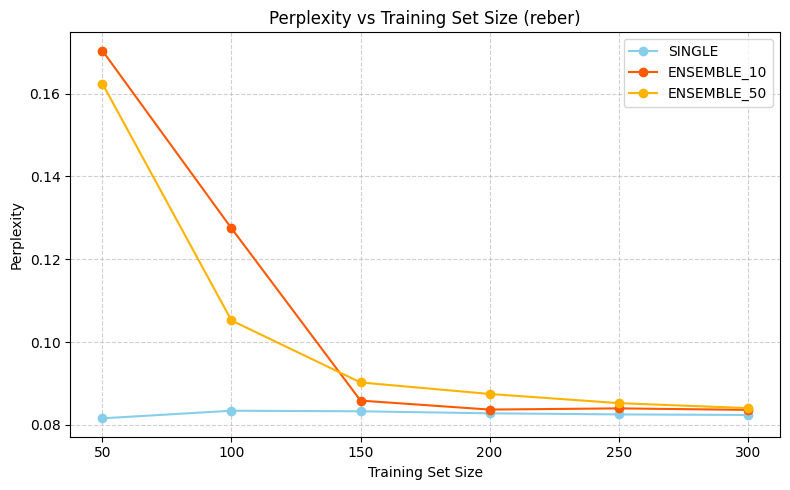

In [8]:
reber_train_sizes = [i for i in range(50, 301, 50)]
evaluate_models_trainsize_varied(REBER_CONFIG, machines.reber(), reber_train_sizes, 100, ensemble_sizes = [10, 50])

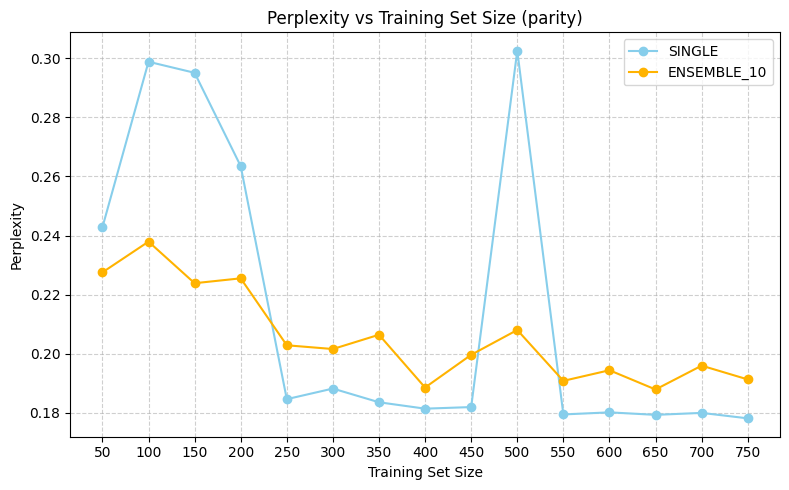

In [10]:
parity_train_sizes = [i for i in range(50, 751, 50)]
evaluate_models_trainsize_varied(PARITY_CONFIG, machines.parity_machine(), parity_train_sizes, test_size=500, ensemble_sizes=[10])